In [1]:
# %matplotlib widget


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import matplotlib.pyplot as plt

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    return X_

def load_Y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_

/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ivan/anaconda3/envs/3DPose/lib/python3.7/site-

In [3]:
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0

In [4]:
def norm_X(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,0*2:0*2+2]
    Neck = X[:,1*2:1*2+2]
    RShoulder = X[:,2*2:2*2+2]
    RElbow = X[:,3*2:3*2+2]
    RWrist = X[:,4*2:4*2+2]
    LShoulder = X[:,5*2:5*2+2]
    LElbow = X[:,6*2:6*2+2]
    LWrist = X[:,7*2:7*2+2]
    RHip = X[:,8*2:8*2+2]
    RKnee = X[:,9*2:9*2+2]
    RAnkle = X[:,10*2:10*2+2]
    LHip = X[:,11*2:11*2+2]
    LKnee = X[:,12*2:12*2+2]
    LAnkle = X[:,13*2:13*2+2]
    REye = X[:,14*2:14*2+2]
    LEye = X[:,15*2:15*2+2]
    REar = X[:,16*2:16*2+2]
    LEar = X[:,17*2:17*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
    #length_head      = np.sqrt(np.square((LEye[:,0:1]+REye[:,0:1])/2 - Neck[:,0:1]) + np.square((LEye[:,1:2]+REye[:,1:2])/2 - Neck[:,1:2]))

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
    #length_leg_right = np.sqrt(np.square(RHip[:,0:1]-RKnee[:,0:1]) + np.square(RHip[:,1:2]-RKnee[:,1:2])) \
    #+ np.sqrt(np.square(RKnee[:,0:1]-RAnkle[:,0:1]) + np.square(RKnee[:,1:2]-RAnkle[:,1:2]))

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
    #length_leg_left = np.sqrt(np.square(LHip[:,0:1]-LKnee[:,0:1]) + np.square(LHip[:,1:2]-LKnee[:,1:2])) \
    #+ np.sqrt(np.square(LKnee[:,0:1]-LAnkle[:,0:1]) + np.square(LKnee[:,1:2]-LAnkle[:,1:2]))

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

In [5]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 36)
    Nose = skeleton[:,0*2:0*2+2][0]
    Neck = skeleton[:,1*2:1*2+2][0]
    RShoulder = skeleton[:,2*2:2*2+2][0]
    RElbow = skeleton[:,3*2:3*2+2][0]
    RWrist = skeleton[:,4*2:4*2+2][0]
    LShoulder = skeleton[:,5*2:5*2+2][0]
    LElbow = skeleton[:,6*2:6*2+2][0]
    LWrist = skeleton[:,7*2:7*2+2][0]
    RHip = skeleton[:,8*2:8*2+2][0]
    RKnee = skeleton[:,9*2:9*2+2][0]
    RAnkle = skeleton[:,10*2:10*2+2][0]
    LHip = skeleton[:,11*2:11*2+2][0]
    LKnee = skeleton[:,12*2:12*2+2][0]
    LAnkle = skeleton[:,13*2:13*2+2][0]
    REye = skeleton[:,14*2:14*2+2][0]
    LEye = skeleton[:,15*2:15*2+2][0]
    REar = skeleton[:,16*2:16*2+2][0]
    LEar = skeleton[:,17*2:17*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot(sample):
    # sample is one-dimension array
    # e.g: (36,)
    if sample.shape[0] == 36:
        sample_norm = norm_X(sample.reshape(1,36))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (36,)")

In [6]:
# Create a model
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid', input_shape=(36,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])
model.summary()

# plot training log
def plot_history(history):
    history_dict = history.history
    history_dict.keys()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'ro', label='Validation loss')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation loss/acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2368      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
____

In [7]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])

In [8]:
# Load and norminalize dataset
X_train = load_X('dataset/X_train.txt')
Y_train = load_Y('dataset/Y_train.txt')
X_train_norm = norm_X(X_train)

X_test = load_X('dataset/X_test.txt')
Y_test = load_Y('dataset/Y_test.txt')
X_test_norm = norm_X(X_test)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/X_train.txt'

In [9]:
history = model.fit(X_train_norm, Y_train, validation_data=(X_test_norm, Y_test), epochs=500, batch_size=32, verbose=1)#, callbacks= [earlyStopping])

NameError: name 'X_train_norm' is not defined

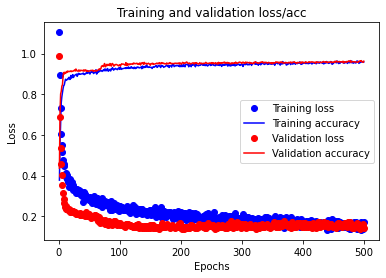

In [21]:
plot_history(history)

In [22]:
# save model 
model.save('pose_classifier.h5')

Estimated pose:
STANDING: 	0.05383162
BENDING: 	0.013991522
CROUCHING: 	0.9321768


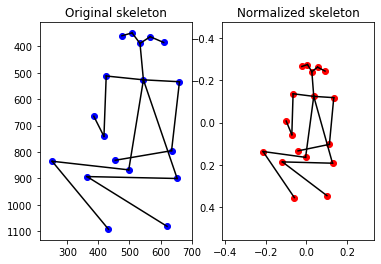

In [23]:
# Testing on single example
LABELS = ["STANDING", "BENDING", "CROUCHING"]

X_sample = load_X('dataset/X_sample.txt')
X_sample_norm = norm_X(X_sample)
y_out = model.predict(X_sample_norm[0].reshape(1, 36))

print("Estimated pose:")
for idx in range(len(LABELS)):
    print(LABELS[idx] + ": \t" + str(y_out[0][idx]))
plot(X_sample[0])


In [24]:
X_sample[0]

array([ 533.882  ,  388.70547,  544.8678 ,  526.60767,  425.08575,
        512.1124 ,  417.78983,  740.82495,  385.09637,  664.53375,
        660.9374 ,  533.8324 ,  635.50964,  795.03125,  454.12094,
        831.36127,  497.63477,  867.6868 ,  250.93797,  835.04785,
        432.3186 , 1092.6522 ,  653.5648 ,  900.40186,  363.2616 ,
        893.10504,  621.06165, 1081.7125 ,  508.40002,  348.8913 ,
        566.73413,  363.1943 ,  475.6909 ,  359.54095,  610.0567 ,
        385.11093], dtype=float32)

In [25]:
X_sample_norm[0]

array([ 0.02696206, -0.24112062,  0.03626795, -0.12430575, -0.06519762,
       -0.13658445, -0.07137789,  0.0571545 , -0.09907202, -0.00747063,
        0.13458875, -0.11818579,  0.1130493 ,  0.10307184, -0.04060235,
        0.13384645, -0.00374244,  0.16461729, -0.21271559,  0.1369693 ,
       -0.05907078,  0.3551821 ,  0.12834357,  0.1923297 , -0.11756794,
        0.18614868,  0.10081062,  0.34591525,  0.00537665, -0.27484662,
        0.05479059, -0.26273075, -0.02233077, -0.26582545,  0.09148849,
       -0.24416551])

In [26]:
X_train.shape

(2676, 36)

In [27]:
X_train_norm

array([[-0.06378927, -0.32805909,  0.04035647, ..., -0.        ,
         0.02647038, -0.30028689],
       [-0.16565792, -0.24813442,  0.01409855, ..., -0.32215179,
        -0.10221446, -0.27985615],
       [-0.1786875 , -0.25772235,  0.01718149, ..., -0.31957571,
        -0.09621634, -0.26803124],
       ...,
       [ 0.09145509, -0.20297831, -0.04005403, ..., -0.2595356 ,
        -0.        , -0.        ],
       [-0.09871121, -0.16568105,  0.09543595, ..., -0.        ,
        -0.02479915, -0.31357428],
       [-0.18946615, -0.18003524,  0.02389214, ..., -0.        ,
        -0.10412145, -0.29637347]])

## Load and Normalize Alpha Pose

In [10]:
index_alphapose={
    # Use 17 skeleton point
    "Nose": 0,
    #"Neck": "-",
    "RShoulder": 6,
    "RElbow": 8,
    "RWrist": 10,
    "LShoulder": 5,
    "LElbow": 7,
    "LWrist": 9,
    "RHip": 12,
    "RKnee": 14,
    "RAnkle": 16,
    "LHip": 11,
    "LKnee": 13,
    "LAnkle": 15,
    "REye": 2,
    "LEye": 1,
    "REar": 4,
    "LEar": 3
}


In [11]:
def find_neck_plot(alpha_example):
    
    x1= alpha_example[:,0] 
    y1= alpha_example[:,1]


    # 12 and 13 is x and y coordinate for right shoulder of alpha pose
    x2= alpha_example[:,2]
    y2= alpha_example[:,3]

    neck_= [float((x1 + x2)/2), float((y1 + y2)/2)]
    neck_=np.asarray(neck_)

    return neck_

def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton_alpha(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 34)
    Nose = skeleton[:,index_alphapose['Nose']*2:index_alphapose['Nose']*2+2][0]
    print("skeleton:",skeleton)

    Neck = find_neck_plot(skeleton)
    print("Neck:",Neck)

    RShoulder = skeleton[:,index_alphapose['RShoulder']*2:index_alphapose['RShoulder']*2+2][0]
    RElbow = skeleton[:,index_alphapose['RElbow']*2:index_alphapose['RElbow']*2+2][0]
    RWrist = skeleton[:,index_alphapose['RWrist']*2:index_alphapose['RWrist']*2+2][0]
    LShoulder = skeleton[:,index_alphapose['LShoulder']*2:index_alphapose['LShoulder']*2+2][0]
    LElbow = skeleton[:,index_alphapose['LElbow']*2:index_alphapose['LElbow']*2+2][0]
    LWrist = skeleton[:,index_alphapose['LWrist']*2:index_alphapose['LWrist']*2+2][0]
    RHip = skeleton[:,index_alphapose['RHip']*2:index_alphapose['RHip']*2+2][0]
    RKnee = skeleton[:,index_alphapose['RKnee']*2:index_alphapose['RKnee']*2+2][0]
    RAnkle = skeleton[:,index_alphapose['RAnkle']*2:index_alphapose['RAnkle']*2+2][0]
    LHip = skeleton[:,index_alphapose['LHip']*2:index_alphapose['LHip']*2+2][0]
    LKnee = skeleton[:,index_alphapose['LKnee']*2:index_alphapose['LKnee']*2+2][0]
    LAnkle = skeleton[:,index_alphapose['LAnkle']*2:index_alphapose['LAnkle']*2+2][0]
    REye = skeleton[:,index_alphapose['REye']*2:index_alphapose['REye']*2+2][0]
    LEye = skeleton[:,index_alphapose['LEye']*2:index_alphapose['LEye']*2+2][0]
    REar = skeleton[:,index_alphapose['REar']*2:index_alphapose['REar']*2+2][0]
    LEar = skeleton[:,index_alphapose['LEar']*2:index_alphapose['LEar']*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot_alpha(sample):
    # sample is one-dimension array
    # e.g: (34,)
    if sample.shape[0] == 34:
        sample_norm = norm_alpha(sample.reshape(1,34))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_alpha(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_alpha(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (36,)")

In [12]:
import json 
import numpy as np
import torch

# Opening JSON file 
f = open('alphapose-results.json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  

# Closing file 
f.close() 

In [37]:
len(data[150]['keypoints'])

51

In [13]:
def data_converter(data):
    data=data['keypoints']
    keypoints=[]
    kp_score=[]
    for a in range (0,len(data)):
        score=[]
        if ((a+3)%3==0):
            keypoints.append(data[a])
            keypoints.append(data[a+1])
        elif((a+1)%3==0):
            score=[data[a]]
            kp_score.append(score)

    return keypoints
    

In [14]:
alpha_example=np.asarray(data_converter(data[150]))
alpha_example = np.append(alpha_example,data_converter(data[150]))
alpha_example = alpha_example.reshape(2, 34)

In [118]:
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0


# Function to find next in alpha pose because alpha pose did not have neck

def find_neck(alpha_example):
    
    # 10 and 11 is x and y coordinate for left shoulder of alpha pose
    x1= alpha_example[:,10] 
    y1= alpha_example[:,11]
    
    
    # 12 and 13 is x and y coordinate for right shoulder of alpha pose
    x2= alpha_example[:,12]
    y2= alpha_example[:,13]
    
    # Result will be  neck coordinate(array([586.35131836, 472.55082703]), array([559.9307251 , 480.63751221])) ((x1,x2),(y1,y2))
    neck_= ((x1 + x2)/2, (y1 + y2)/2)
    
    result_neck=[]
    for a,b in zip(neck_[0],neck_[1]):
        result_neck.append([a,b])
    
    neck=np.asarray(result_neck)
    return neck

def norm_alpha(X):
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,index_alphapose['Nose']*2:index_alphapose['Nose']*2+2]
    Neck = find_neck(X)
    RShoulder = X[:,index_alphapose['RShoulder']*2:index_alphapose['RShoulder']*2+2]
    RElbow = X[:,index_alphapose['RElbow']*2:index_alphapose['RElbow']*2+2]
    RWrist = X[:,index_alphapose['RWrist']*2:index_alphapose['RWrist']*2+2]
    LShoulder = X[:,index_alphapose['LShoulder']*2:index_alphapose['LShoulder']*2+2]
    LElbow = X[:,index_alphapose['LElbow']*2:index_alphapose['LElbow']*2+2]
    LWrist = X[:,index_alphapose['LWrist']*2:index_alphapose['LWrist']*2+2]
    RHip = X[:,index_alphapose['RHip']*2:index_alphapose['RHip']*2+2]
    RKnee = X[:,index_alphapose['RKnee']*2:index_alphapose['RKnee']*2+2]
    RAnkle = X[:,index_alphapose['RAnkle']*2:index_alphapose['RAnkle']*2+2]
    LHip = X[:,index_alphapose['LHip']*2:index_alphapose['LHip']*2+2]
    LKnee = X[:,index_alphapose['LKnee']*2:index_alphapose['LKnee']*2+2]
    LAnkle = X[:,index_alphapose['LAnkle']*2:index_alphapose['LAnkle']*2+2]
    REye = X[:,index_alphapose['REye']*2:index_alphapose['REye']*2+2]
    LEye = X[:,index_alphapose['LEye']*2:index_alphapose['LEye']*2+2]
    REar = X[:,index_alphapose['REar']*2:index_alphapose['REar']*2+2]
    LEar = X[:,index_alphapose['LEar']*2:index_alphapose['LEar']*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
    #length_head      = np.sqrt(np.square((LEye[:,0:1]+REye[:,0:1])/2 - Neck[:,0:1]) + np.square((LEye[:,1:2]+REye[:,1:2])/2 - Neck[:,1:2]))

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
    #length_leg_right = np.sqrt(np.square(RHip[:,0:1]-RKnee[:,0:1]) + np.square(RHip[:,1:2]-RKnee[:,1:2])) \
    #+ np.sqrt(np.square(RKnee[:,0:1]-RAnkle[:,0:1]) + np.square(RKnee[:,1:2]-RAnkle[:,1:2]))

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
    #length_leg_left = np.sqrt(np.square(LHip[:,0:1]-LKnee[:,0:1]) + np.square(LHip[:,1:2]-LKnee[:,1:2])) \
    #+ np.sqrt(np.square(LKnee[:,0:1]-LAnkle[:,0:1]) + np.square(LKnee[:,1:2]-LAnkle[:,1:2]))

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    print("Num_pts :",num_pts)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    print("Center X :",centr_x)

    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts
    print("Center Y :",centr_y)


    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

In [26]:
alpha_example.shape

(2, 34)

In [119]:
alpha_norm=norm_alpha(alpha_example)

Num_pts : [[17]
 [17]]
Center X : [[660.33580107]
 [660.33580107]]
Center Y : [[470.667134]
 [470.667134]]


In [123]:
alpha_norm.shape

(2, 34)

Num_pts : [[17]]
Center X : [[660.33580107]]
Center Y : [[470.667134]]
skeleton: [[621.59161377 530.50286865 606.00219727 518.81085205 609.89953613
  538.29754639 578.72076416 499.3241272  594.31011963 573.37371826
  559.23400879 456.45330811 613.79693604 596.75775146 547.54199219
  359.01959229 660.56506348 651.32061768 539.74731445 265.48327637
  707.33319092 698.08880615 676.15447998 413.5824585  715.12792969
  475.94000244 746.30670166 300.55938721 812.56158447 440.8638916
  765.793396   304.45672607 871.02178955 378.50634766]]
Neck: [613.79690552 524.65686035]
skeleton: [[-0.10029696  0.15489659 -0.14065324  0.1246295  -0.13056421  0.17507465
  -0.2112766   0.07418427 -0.17092048  0.26587623 -0.26172191 -0.03679529
  -0.12047502  0.32641041 -0.291989   -0.28902166  0.00059349  0.46765714
  -0.31216706 -0.53115884  0.121662    0.58872581  0.04094977 -0.14777493
   0.14184022  0.01364986  0.22255261 -0.44035742  0.39406643 -0.07715156
   0.27299776 -0.43026839  0.54540219 -0.2385763

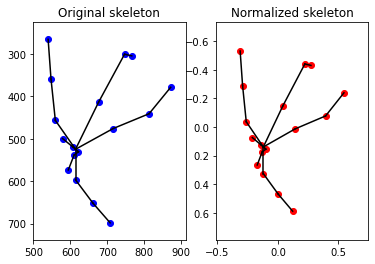

In [242]:
# Testing on single example

plot_alpha(alpha_example[0])


## Load and Normalize Human Eva

<img src="img/humanevaskeleton.png" >

In [216]:
index_humaneva={
    # Use 15 skeleton point
    "Pelvis": 0,
    "Head": 14,
    "Thorax":1,
    "RShoulder": 5,
    "RElbow": 6,
    "RWrist": 7,
    "LShoulder": 2,
    "LElbow": 3,
    "LWrist": 4,
    "RHip": 11,
    "RKnee": 12,
    "RAnkle": 13,
    "LHip": 8,
    "LKnee": 9,
    "LAnkle": 10,
}

def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0


def norm_humaneva(X):
    num_sample = X.shape[0]
    # Keypoints
    Pelvis = X[:,index_humaneva['Pelvis']*2:index_humaneva['Pelvis']*2+2]
    Head = X[:,index_humaneva['Head']*2:index_humaneva['Head']*2+2]
    Thorax = X[:,index_humaneva['Thorax']*2:index_humaneva['Thorax']*2+2]
    RShoulder = X[:,index_humaneva['RShoulder']*2:index_humaneva['RShoulder']*2+2]
    RElbow = X[:,index_humaneva['RElbow']*2:index_humaneva['RElbow']*2+2]
    RWrist = X[:,index_humaneva['RWrist']*2:index_humaneva['RWrist']*2+2]
    LShoulder = X[:,index_humaneva['LShoulder']*2:index_humaneva['LShoulder']*2+2]
    LElbow = X[:,index_humaneva['LElbow']*2:index_humaneva['LElbow']*2+2]
    LWrist = X[:,index_humaneva['LWrist']*2:index_humaneva['LWrist']*2+2]
    RHip = X[:,index_humaneva['RHip']*2:index_humaneva['RHip']*2+2]
    RKnee = X[:,index_humaneva['RKnee']*2:index_humaneva['RKnee']*2+2]
    RAnkle = X[:,index_humaneva['RAnkle']*2:index_humaneva['RAnkle']*2+2]
    LHip = X[:,index_humaneva['LHip']*2:index_humaneva['LHip']*2+2]
    LKnee = X[:,index_humaneva['LKnee']*2:index_humaneva['LKnee']*2+2]
    LAnkle = X[:,index_humaneva['LAnkle']*2:index_humaneva['LAnkle']*2+2]


    # Length of head
    length_Head_Thorax = euclidean_dist(Head, Thorax)
    length_head      = np.maximum.reduce([length_Head_Thorax])

    # Length of torso
    length_Thorax_LHip = euclidean_dist(Thorax, LHip)
    length_Thorax_RHip = euclidean_dist(Thorax, RHip)
    length_torso     = np.maximum(length_Thorax_LHip, length_Thorax_RHip)

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
  
    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)


    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

In [219]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton_humaneva(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 30)
    # Keypoints
    Pelvis = skeleton[:,index_humaneva['Pelvis']*2:index_humaneva['Pelvis']*2+2][0]
    Head = skeleton[:,index_humaneva['Head']*2:index_humaneva['Head']*2+2][0]
    Thorax = skeleton[:,index_humaneva['Thorax']*2:index_humaneva['Thorax']*2+2][0]
    RShoulder = skeleton[:,index_humaneva['RShoulder']*2:index_humaneva['RShoulder']*2+2][0]
    RElbow = skeleton[:,index_humaneva['RElbow']*2:index_humaneva['RElbow']*2+2][0]
    RWrist = skeleton[:,index_humaneva['RWrist']*2:index_humaneva['RWrist']*2+2][0]
    LShoulder = skeleton[:,index_humaneva['LShoulder']*2:index_humaneva['LShoulder']*2+2][0]
    LElbow = skeleton[:,index_humaneva['LElbow']*2:index_humaneva['LElbow']*2+2][0]
    LWrist = skeleton[:,index_humaneva['LWrist']*2:index_humaneva['LWrist']*2+2][0]
    RHip = skeleton[:,index_humaneva['RHip']*2:index_humaneva['RHip']*2+2][0]
    RKnee = skeleton[:,index_humaneva['RKnee']*2:index_humaneva['RKnee']*2+2][0]
    RAnkle = skeleton[:,index_humaneva['RAnkle']*2:index_humaneva['RAnkle']*2+2][0]
    LHip = skeleton[:,index_humaneva['LHip']*2:index_humaneva['LHip']*2+2][0]
    LKnee = skeleton[:,index_humaneva['LKnee']*2:index_humaneva['LKnee']*2+2][0]
    LAnkle = skeleton[:,index_humaneva['LAnkle']*2:index_humaneva['LAnkle']*2+2][0]
    LEar = skeleton[:,index_alphapose['LEar']*2:index_alphapose['LEar']*2+2][0]


    plot_line(Head, Thorax)
    plot_line(Thorax, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Thorax, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Thorax, Pelvis)
    plot_line(Pelvis, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Pelvis, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot_humaneva(sample):
    # sample is one-dimension array
    # e.g: (30,)
    if sample.shape[0] == 30:
        sample_norm = norm_humaneva(sample.reshape(1,30))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_humaneva(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton_humaneva(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (30,)")

In [225]:
import numpy as np

humaneva_2D = np.load('../Dataset/HumanEva-I/converted_15j/data_2d_humaneva15_gt.npz',allow_pickle=True)
skeleton_2d=humaneva_2D['positions_2d']

#Camera 1 
skeleton_2d.item()['Train/S1']['Box 1 chunk1'][0]

new_array=np.asarray([b.reshape(-1) for a in skeleton_2d.item()['Train/S1']['Box 1 chunk1'] for b in a])
skeleton_2d_unnormalized=new_array.reshape(len(skeleton_2d.item()['Train/S1']['Box 1 chunk1']),
                            int(new_array.shape[0]/3),
                            skeleton_2d.item()['Train/S1']['Box 1 chunk1'][0][0].shape[0]*skeleton_2d.item()['Train/S1']['Box 1 chunk1'][0][0].shape[1])


In [234]:
humaneva_example=skeleton_2d_unnormalized[0]
humaneva_norm=norm_humaneva(humaneva_example)
humaneva_norm.shape

(28, 30)

In [231]:
humaneva_norm[0]

array([ 0.01782327,  0.01572455,  0.01061098, -0.26456118,  0.11898812,
       -0.25947426,  0.13513113, -0.0657169 ,  0.00927557, -0.09095033,
       -0.0846463 , -0.25318207, -0.10584009, -0.07499859, -0.04569497,
       -0.16359957,  0.03826999,  0.03203881,  0.06745455,  0.28221093,
        0.05008027,  0.49526239, -0.02244487,  0.02768115, -0.08548389,
        0.27998912, -0.1064212 ,  0.5125464 ,  0.00289803, -0.47296987])

In [235]:
skeleton_2d_unnormalized.shape

(3, 28, 30)

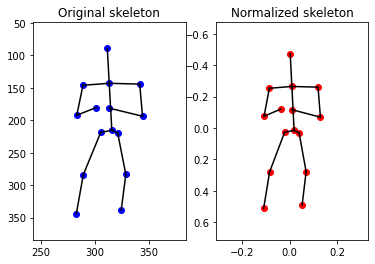

In [241]:
# Testing on single example

plot_humaneva(skeleton_2d_unnormalized[0][3])
